In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import plotly.express as px

In [2]:
# Function to show data quality of each column
def summary(dtf):
    sumary=pd.concat([dtf.isna().sum(),((dtf == 0).sum())/dtf.shape[0],dtf.dtypes], axis=1)
    sumary=sumary.rename(columns={sumary.columns[0]: 'NaN'})
    sumary=sumary.rename(columns={sumary.columns[1]: 'Zeros'})
    sumary=sumary.rename(columns={sumary.columns[2]: 'Type'})
    sumary['NaN']=sumary['NaN'].astype(str)+' ('+((sumary['NaN']*100/dtf.shape[0]).astype(int)).astype(str)+'%)'
    sumary['Zeros']=(sumary['Zeros']*100).astype(int)
    sumary['Zeros']=(dtf == 0).sum().astype(str)+' ('+sumary['Zeros'].astype(str)+'%)'
    sumary=sumary[['Type','NaN','Zeros']]
    return print(sumary)

In [3]:
df=pd.read_csv("SDA, Delivery - h_t - h_t data.csv")
df.columns

Index(['Time', 'Category level 0', 'Category level 1', 'Category level 2',
       'Unique SKUs Listed', 'Unique SKUs Sold', '# of sold SKU items',
       'Price before Discount (includ. VAT) (EUR)', 'Discount Value (EUR)',
       'Item COGS (net VAT) (EUR)', 'Waste, # of items'],
      dtype='object')

# Cleaning

In [4]:
# Renaming columns for better usability

df.rename(columns={'Time':'time','Category level 0':'category_lvl_0','Category level 1':'category_lvl_1',
                   'Category level 2':'category_lvl_2','Unique SKUs Listed':'unique_skus',
                  'Unique SKUs Sold':'unique_sku_sold','# of sold SKU items':'total_sold',
                  'Price before Discount (includ. VAT) (EUR)':'total_price',
                  'Discount Value (EUR)':'discount','Item COGS (net VAT) (EUR)':'supplier_costprice',
                  'Waste, # of items':'waste_count'}, inplace=True
         )

In [5]:
df.head(3)

,time,category_lvl_0,category_lvl_1,category_lvl_2,unique_skus,unique_sku_sold,total_sold,total_price,discount,supplier_costprice,waste_count
0,2023-09-17,Fresh Food,🧀 Cheese,Hard Cheese,26,17,37,135.812592,10.491467,88.81738,0
1,2023-08-02,Fresh Food,🍞 Bakery,Gluten Free,1,0,0,0.000000,0.000000,0.00000,0
2,2023-08-26,Fresh Food,🥛 Dairy & Eggs,Sour Cream & Cream,14,10,26,53.454514,3.213313,31.87778,0


In [6]:
summary(df)

                       Type     NaN        Zeros
time                 object  0 (0%)       0 (0%)
category_lvl_0       object  0 (0%)       0 (0%)
category_lvl_1       object  0 (0%)       0 (0%)
category_lvl_2       object  0 (0%)       0 (0%)
unique_skus           int64  0 (0%)     220 (1%)
unique_sku_sold       int64  0 (0%)   2136 (12%)
total_sold            int64  0 (0%)   2136 (12%)
total_price         float64  0 (0%)   2136 (12%)
discount            float64  0 (0%)   4609 (26%)
supplier_costprice  float64  0 (0%)   2136 (12%)
waste_count           int64  0 (0%)  15160 (87%)


In [7]:
df_nosku=df[df['unique_skus']==0]
df_nosku.head()

,time,category_lvl_0,category_lvl_1,category_lvl_2,unique_skus,unique_sku_sold,total_sold,total_price,discount,supplier_costprice,waste_count
150,2023-09-30,Fresh Food,🍞 Bakery,Daily Baked Pastries,0,0,0,0.0,0.0,0.0,0
162,2023-09-12,Fresh Food,🍞 Bakery,Daily Baked Pastries,0,0,0,0.0,0.0,0.0,0
245,2023-08-31,Fresh Food,🍞 Bakery,Daily Baked Pastries,0,0,0,0.0,0.0,0.0,0
399,2023-09-23,Fresh Food,🍞 Bakery,Daily Baked Pastries,0,0,0,0.0,0.0,0.0,0
684,2023-09-24,Fresh Food,🍞 Bakery,Daily Baked Pastries,0,0,0,0.0,0.0,0.0,0


In [8]:
# Checking if there are any sale even if unique SKU is zero : which should be impossible
print('Total Sold:')
print(df_nosku.total_sold.sum())
df_nosku.query('total_sold>0')

Total Sold:
10


,time,category_lvl_0,category_lvl_1,category_lvl_2,unique_skus,unique_sku_sold,total_sold,total_price,discount,supplier_costprice,waste_count
3630,2023-09-22,Fresh Food,🥪 Fresh & Ready,Sushi,0,1,2,12.072598,0.905747,7.64048,0
3658,2023-07-12,Fresh Food,🥪 Fresh & Ready,Sushi,0,1,1,6.059280,0.000000,3.83478,0
3962,2023-07-05,Fresh Food,🥪 Fresh & Ready,Sushi,0,1,3,18.168021,2.120309,11.49813,0
4205,2023-07-21,Fresh Food,🥪 Fresh & Ready,Sushi,0,1,4,24.302696,0.000000,15.38064,0


In [9]:
#Setting Sushi also as a unique SKU by assigning it as 1

df['unique_skus'].mask(((df['unique_skus']==0) & (df['total_sold'] > 0)) , 1 , inplace=True)

We noticed in the summary stats that almost 1%(220 records) in the dataset has no Unique SKU's
Which only means there is nothing to be sold and obviously the rest of fields are empty as observed above.
Hence these records can be straight removed.

In [10]:
df=df[df['unique_skus']!=0].reset_index(drop=True)
df.query('total_price==0').head()

,time,category_lvl_0,category_lvl_1,category_lvl_2,unique_skus,unique_sku_sold,total_sold,total_price,discount,supplier_costprice,waste_count
1,2023-08-02,Fresh Food,🍞 Bakery,Gluten Free,1,0,0,0.0,0.0,0.0,0
11,2023-08-16,Fresh Food,🍞 Bakery,Gluten Free,1,0,0,0.0,0.0,0.0,0
22,2023-07-10,Fresh Food,🍞 Bakery,Gluten Free,1,0,0,0.0,0.0,0.0,0
75,2023-08-16,Fresh Food,🍞 Bakery,Daily Baked Pastries,2,0,0,0.0,0.0,0.0,0
97,2023-09-24,Fresh Food,🍞 Bakery,Gluten Free,1,0,0,0.0,0.0,0.0,0


Now the dataset has dates when nothing was bought from above categories. We should not remove these records as this suggests a decline in sale of these particular categories over a period.

In [11]:
# Check for duplicates if any extra entry for a given date and category

df.loc[df.duplicated(subset=['time','category_lvl_0','category_lvl_1','category_lvl_2'])].reset_index(drop=True)

,time,category_lvl_0,category_lvl_1,category_lvl_2,unique_skus,unique_sku_sold,total_sold,total_price,discount,supplier_costprice,waste_count


# Outliers

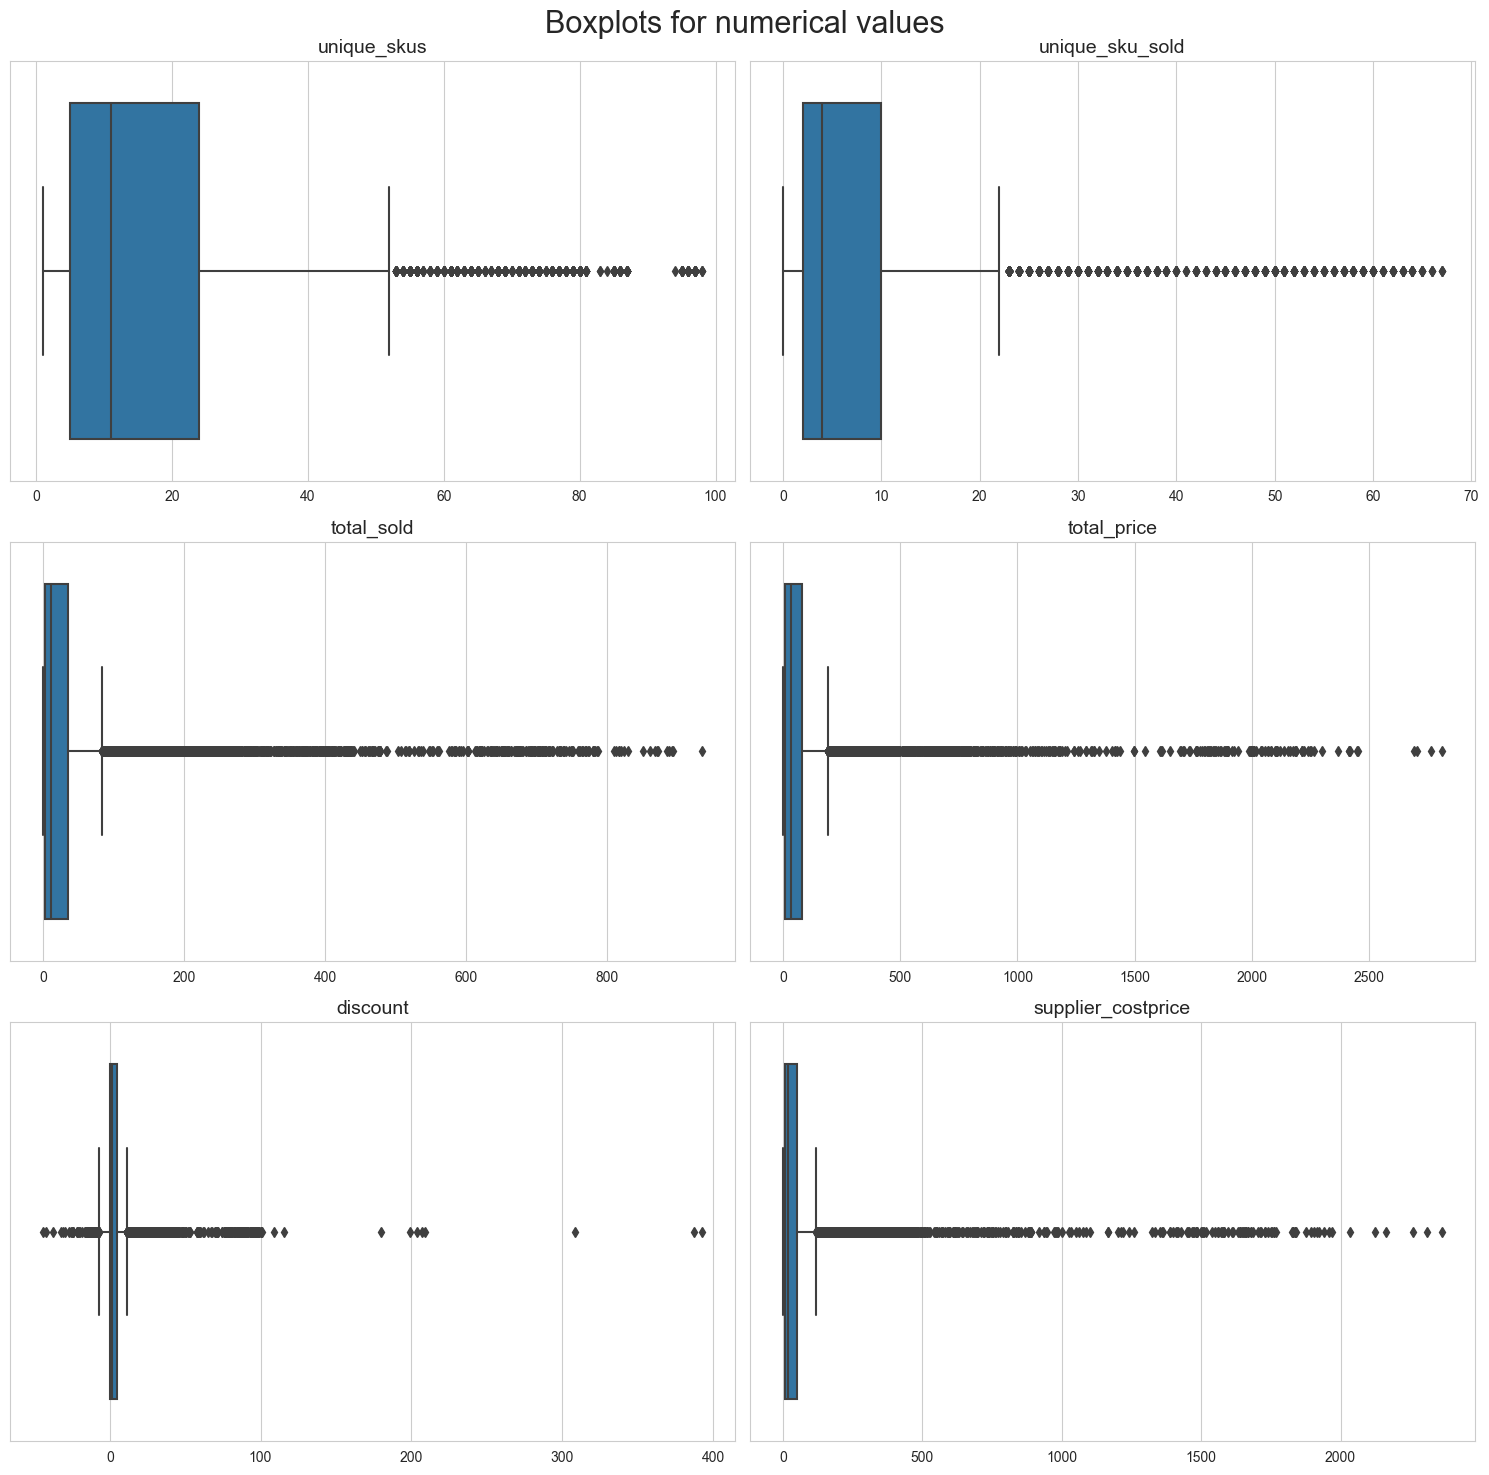

In [12]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
fig.suptitle('Boxplots for numerical values', fontsize=22)

axes = axes.flatten()

# List of numerical columns to plot
num_cols = ['unique_skus', 'unique_sku_sold', 'total_sold', 'total_price', 'discount', 'supplier_costprice']

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col, fontsize=14)
    axes[i].set_xlabel('')
plt.tight_layout()
plt.show()


We can infer a few things about the outliers present in the dataset from above boxplots for all the numerical columns.
* For few cases, the total sold SKU's are abnormally high. This might be genuine or high chances of an outlier.
* There exists few discounts which are negative. This should not be practically possible, hence needs handling. Also few of the discounts seem really high to be realistic unless total price is also very high.

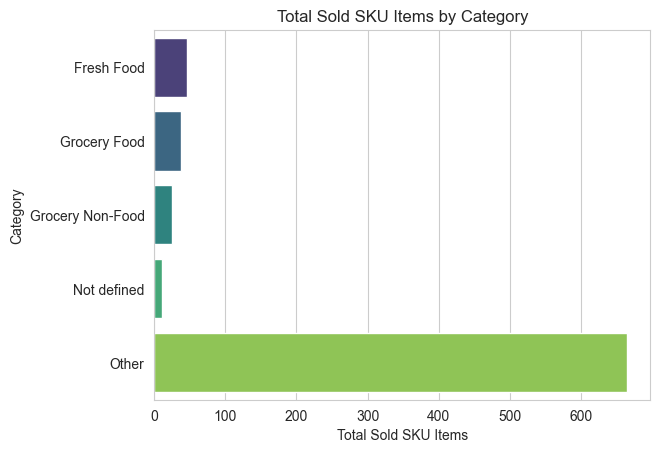

In [13]:
# Barplot for number of sold SKU items
sns.barplot(x='total_sold', y='category_lvl_0', data=df, palette='viridis',errorbar=None)
plt.title('Total Sold SKU Items by Category')
plt.xlabel('Total Sold SKU Items')
plt.ylabel('Category')
plt.show()

In [15]:
#Above barplot suggests , there is clearly something fishy with the category 'Other' which is apparently sold most
df.loc[df['category_lvl_0']=='Other'].sort_values('time')

,time,category_lvl_0,category_lvl_1,category_lvl_2,unique_skus,unique_sku_sold,total_sold,total_price,discount,supplier_costprice,waste_count
17175,2023-07-01,Other,♻️ Save me!,Packaging fee,1,1,703,182.912684,96.791236,112.01759,0
17151,2023-07-02,Other,♻️ Save me!,Packaging fee,1,1,766,199.569578,100.827025,122.21918,0
17126,2023-07-03,Other,♻️ Save me!,Packaging fee,1,1,705,183.615135,91.416897,112.44750,0
17180,2023-07-04,Other,♻️ Save me!,Packaging fee,1,1,654,170.406894,83.640081,104.35878,0
17146,2023-07-05,Other,♻️ Save me!,Packaging fee,1,1,656,170.884720,90.652260,104.65168,0
...,...,...,...,...,...,...,...,...,...,...,...
17181,2023-09-26,Other,♻️ Save me!,Packaging fee,1,1,585,151.756605,74.192118,92.93895,0
17100,2023-09-27,Other,♻️ Save me!,Packaging fee,1,1,584,151.424776,75.971677,92.73336,0
17096,2023-09-28,Other,♻️ Save me!,Packaging fee,1,1,634,164.384788,88.415162,100.67286,0
17139,2023-09-29,Other,♻️ Save me!,Packaging fee,1,1,701,181.811282,88.960480,111.33979,0


This suggests that there is an entry for every date which gives an idea about how many SKU's needed packaging which is also associated with a price. 
This can be separately analysed while doing a supply analysis

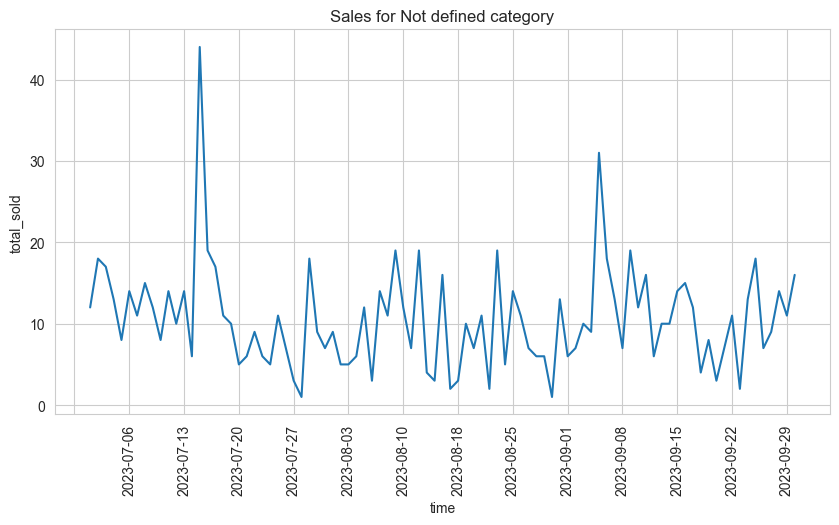

In [16]:
# Removing pakaging data for biasfree commercial analysis
df_commercial = df.loc[df['category_lvl_0']!='Other']

# Vizualizing Not defined category
df_undefined=df_commercial[df_commercial['category_lvl_0']=='Not defined'].sort_values('time')
plt.figure(1, figsize = (10,5))
ax = sns.lineplot(data=df_undefined, x='time', y='total_sold')
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.title('Sales for Not defined category')
plt.show()

Above plot shows that the Not defined category is a legit SKU which has descent sales over time , hence this data cannot be removed from dataset and has to be included for insight computations. 

In [17]:
# Negative discount analysis
df_commercial.query("discount < 0")['discount'].describe()

count    154.000000
mean      -8.960922
std        8.154100
min      -44.296566
25%      -12.078431
50%       -5.471746
75%       -4.042581
max       -0.056695
Name: discount, dtype: float64

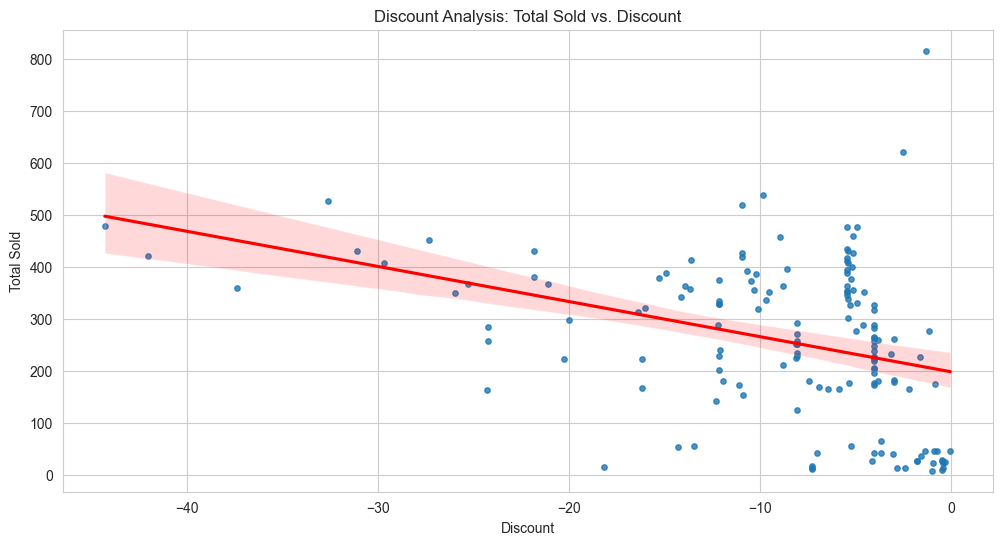

In [18]:
plt.figure(figsize=(12, 6))
sns.regplot(x='discount', y='total_sold', data=df_commercial.query('discount<0'), scatter_kws={'s': 15}, line_kws={'color': 'red'})
plt.title('Discount Analysis: Total Sold vs. Discount')
plt.xlabel('Discount')
plt.ylabel('Total Sold')
plt.show()

Its confirmed from above two observations that 75% of the negative discounts are under 5 and very few are at higher
30's. Also there is no huge difference in those negative discounts with the number of SKU's sold , so this mostly 
has to be some kind of error for having negative discounts or might have some definite meaning for being negative.
Fow now , we can exclude those 150 records for better statistical insights

In [19]:
# Dropping negative discounts
df_commercial=df_commercial.query('discount>=0').reset_index(drop=True)
df_commercial

,time,category_lvl_0,category_lvl_1,category_lvl_2,unique_skus,unique_sku_sold,total_sold,total_price,discount,supplier_costprice,waste_count
0,2023-09-17,Fresh Food,🧀 Cheese,Hard Cheese,26,17,37,135.812592,10.491467,88.81738,0
1,2023-08-02,Fresh Food,🍞 Bakery,Gluten Free,1,0,0,0.000000,0.000000,0.00000,0
2,2023-08-26,Fresh Food,🥛 Dairy & Eggs,Sour Cream & Cream,14,10,26,53.454514,3.213313,31.87778,0
3,2023-09-24,Fresh Food,🥪 Fresh & Ready,Desserts & Sweets,25,13,47,61.698558,3.516517,41.22566,0
4,2023-09-15,Fresh Food,🍗 Meat & Fish,Meat & Fish Alternatives,17,3,8,13.061563,1.358066,8.68154,0
...,...,...,...,...,...,...,...,...,...,...,...
16935,2023-09-22,Not defined,Not defined,Not defined,30,4,11,27.230772,1.086895,16.04580,0
16936,2023-08-20,Not defined,Not defined,Not defined,32,2,7,25.671374,0.768544,14.72366,0
16937,2023-09-28,Not defined,Not defined,Not defined,30,4,14,30.482762,0.000000,18.54975,0
16938,2023-09-13,Not defined,Not defined,Not defined,30,3,10,35.794192,7.162864,20.92520,0


# Analysis and Insights

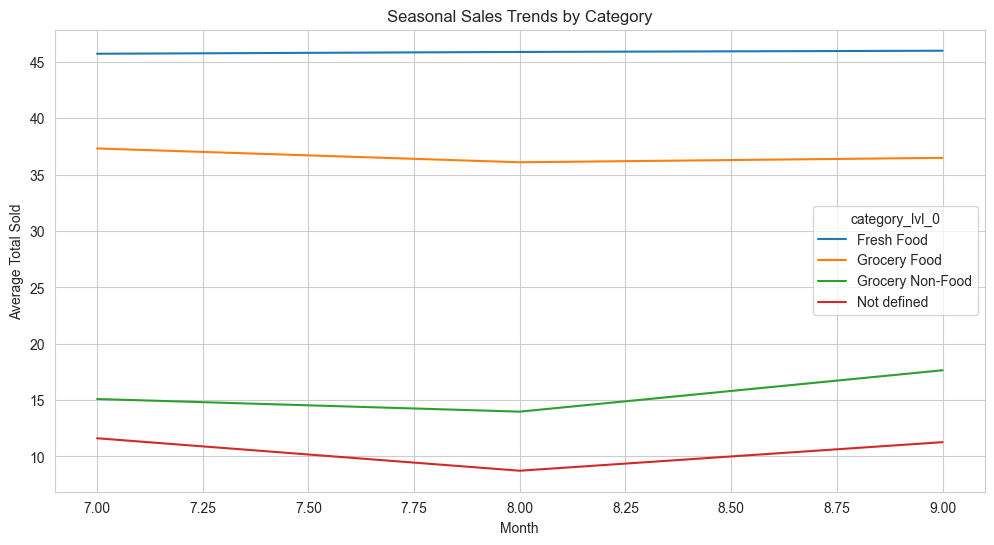

In [20]:
import plotly.express as px

df_commercial['month'] = pd.to_datetime(df_commercial['time']).dt.month
seasonal_trends = df_commercial.groupby(['category_lvl_0', 'month'])['total_sold'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='total_sold', hue='category_lvl_0', data=seasonal_trends)
plt.title('Seasonal Sales Trends by Category')
plt.xlabel('Month')
plt.ylabel('Average Total Sold')
plt.show()

The seasonal plot for Categories across 3 months suggests that there was just a slight dip during last week of July
and first week of August , apart from that , it has been consistent sale for most categories. There was a slight
growth for Grocery towards end of September

In [155]:
import plotly.express as px
fig = px.scatter(df_commercial.sort_values('time'), x='total_price', y='total_sold', animation_frame='time',
                 color='category_lvl_0')
fig.update_layout(title_text='Category sale for 3 months')
fig.show()

The above interactive scatter plot is best way to investigate individual data points which look like outlier on
the plot. The slider helps you move through the timeline to see the concentration of each categories for different
levels of sale. The most evident insight here is that there is always a huge bulk of green dots near origin price
suggesting most of the cheap grocery food are sold easily

In [22]:
import plotly.express as px

fig = px.scatter(df_commercial, x='discount', y='total_sold', color='category_lvl_1',
                 title='Discount Impact on Total Sales by Category')
fig.update_layout(xaxis_title='Discount', yaxis_title='Total Sold')
fig.show()

This plot shows an intresting insight that there is a high demand and sale of Water and flavoured water category
irrespective of discounts . Same is the case with Tobacco as well. Also there is barely any beverage sale without 
discount and has good sale towards the higher side of discounts which suggests that sales might dip if offered 
discounts are compromised. Also there are a noticible amount of Ice-cream sale with very high discount, this is
mainly because of its high cost price

In [23]:
import plotly.express as px

df_commercial['waste_percentage'] = (df_commercial['waste_count'] / df_commercial['total_sold']) * 100

# Handles any waste that has no sale any gievn day
df_commercial['waste_percentage'].mask(((df_commercial['total_sold']==0) & (df_commercial['waste_count'] > 0)) 
                                       , 100 , inplace=True)

waste_percentage_by_category = df_commercial.groupby('category_lvl_1')['waste_percentage'].mean().reset_index()

fig = px.bar(waste_percentage_by_category, x='category_lvl_1', y='waste_percentage',
             title='Average Waste Percentage by Category',text_auto = True)
fig.update_layout(xaxis_title='Category Level 1', yaxis_title='Average Waste Percentage')
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
)
fig.show()

Meat & Fish and Health safety categories alone contribute to atleast 65% of total wastage which is expected due
to their low shelf life but this can be brought down . Notice that the "Not Defined" category also has high
wastage , hence needs investigating. Overall thsi plot gives a very good idea of category wise contribution to 
total waste.

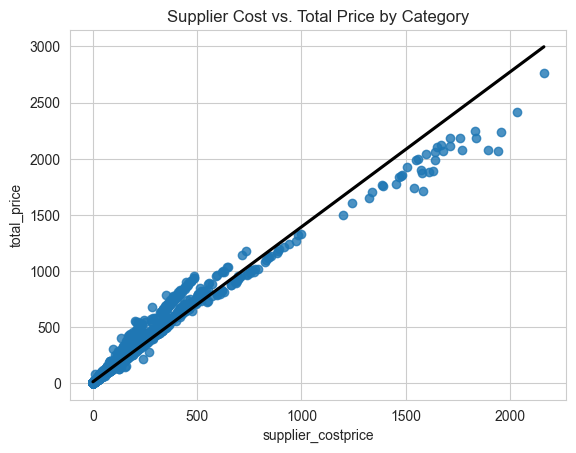

In [24]:
sns.color_palette("tab10")
colors = ['darkorange', 'royalblue', '#555555']
fig = sns.regplot(df_commercial, x='supplier_costprice', y='total_price', ci=None 
                 ,line_kws={"color": "black"})
plt.title('Supplier Cost vs. Total Price by Category')
plt.show()

There exists a fair bit of linear relationship between the COGS and price . With minor parameter tuning and 
transformation, a regression analysis and forecast can be done for either of variables.

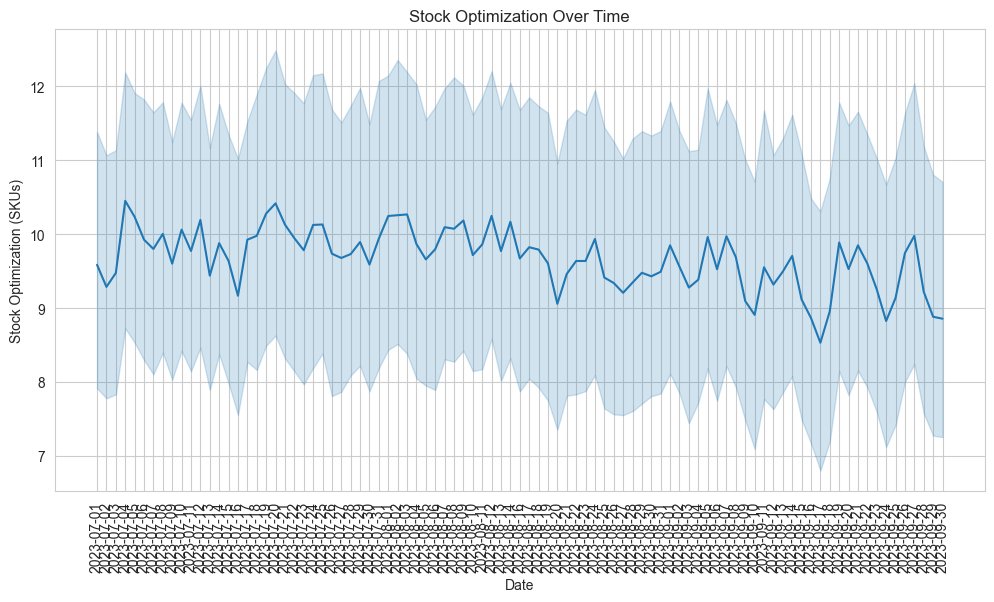

In [151]:
df['stock_optimization'] = df['unique_skus'] - df['unique_sku_sold']
# Plot stock optimization over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='stock_optimization', data=df.sort_values('time'))
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=90)
plt.title('Stock Optimization Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Optimization (SKUs)')
plt.show()

Above plot depicts how well are the stocks optimised and inventory managed . This has been seeing a dip on recent
dates . This can be handled in more assertive way to keep those figures well in balanced and controlled form.

In [129]:
#generating dataframe of dates and the total packaging price on that day
top_packaging_fees=df.loc[df['category_lvl_2'] == "Packaging fee"].sort_values('total_price',ascending=False).head(15)
top_packaging_fees

,time,category_lvl_0,category_lvl_1,category_lvl_2,unique_skus,unique_sku_sold,total_sold,total_price,discount,supplier_costprice,waste_count,stock_optimization
17156,2023-07-13,Other,♻️ Save me!,Packaging fee,1,1,782,204.284988,100.313856,125.10436,0,0
17151,2023-07-02,Other,♻️ Save me!,Packaging fee,1,1,766,199.569578,100.827025,122.21918,0,0
17101,2023-09-10,Other,♻️ Save me!,Packaging fee,1,1,750,195.033966,93.096670,119.44095,0,0
17177,2023-07-16,Other,♻️ Save me!,Packaging fee,1,1,742,194.023644,100.412286,118.82230,0,0
17114,2023-08-20,Other,♻️ Save me!,Packaging fee,1,1,739,192.800914,95.226498,118.07489,0,0
17153,2023-07-14,Other,♻️ Save me!,Packaging fee,1,1,737,192.526510,97.438790,117.90526,0,0
17131,2023-09-24,Other,♻️ Save me!,Packaging fee,1,1,738,191.622552,96.590406,117.35149,0,0
17118,2023-09-17,Other,♻️ Save me!,Packaging fee,1,1,733,190.436284,96.385896,116.62088,0,0
17116,2023-09-16,Other,♻️ Save me!,Packaging fee,1,1,732,189.893360,97.540780,116.28872,0,0
17155,2023-08-16,Other,♻️ Save me!,Packaging fee,1,1,722,188.728634,94.102920,115.57776,0,0


In [130]:
top_15_dates = top_packaging_fees.head(15)['time'].tolist()

# Filter the data for only the top 15 dates
filtered_data = df_commercial[df_commercial['time'].isin(top_15_dates)]
filtered_data_total_sales = filtered_data['total_price'].sum()

# Group by Category level 2 and sum the number of sold SKU items
category_sales = filtered_data.groupby(['category_lvl_1','category_lvl_2'])['total_price'].sum().reset_index()
top_3_categories = category_sales.sort_values(by='total_price', ascending=False).head(3)
top_3_categories['percentage_of_totalSales'] = (top_3_categories['total_price'] / filtered_data_total_sales) * 100

top_3_categories

,category_lvl_1,category_lvl_2,total_price,percentage_of_totalSales
89,💧 Water & Flavoured Water,Still Water,12156.778512,5.178104
90,🚬 Tobacco & Heated Tobacco,Cigarettes & Cigars,11887.411651,5.063369
32,🍦 Ice Cream,Large,11832.758522,5.040090


In [139]:
# Calculate the total sales for each of the top 15 highest packaging fee days
sales_per_day = filtered_data.groupby('time')['total_price'].sum().reset_index()

# Get the sales for the top 3 categories for each day
sales_top_3_per_day = filtered_data[filtered_data['category_lvl_1'].isin(top_3_categories['category_lvl_1'])]
grouped_sales_top_3 = sales_top_3_per_day.groupby(['time', 'category_lvl_1'])['total_price'].sum().reset_index()


/var/folders/4q/7q6th56j183dq_31j06x1dx40000gn/T/ipykernel_68531/4075288715.py:16: UserWarning:

Glyph 128167 (\N{DROPLET}) missing from current font.

/var/folders/4q/7q6th56j183dq_31j06x1dx40000gn/T/ipykernel_68531/4075288715.py:16: UserWarning:

Glyph 128684 (\N{SMOKING SYMBOL}) missing from current font.

/var/folders/4q/7q6th56j183dq_31j06x1dx40000gn/T/ipykernel_68531/4075288715.py:16: UserWarning:

Glyph 127846 (\N{SOFT ICE CREAM}) missing from current font.

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 128167 (\N{DROPLET}) missing from current font.

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 128684 (\N{SMOKING SYMBOL}) missing from current font.

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 127846 (\N{SOFT ICE CREAM}) missing from current font.



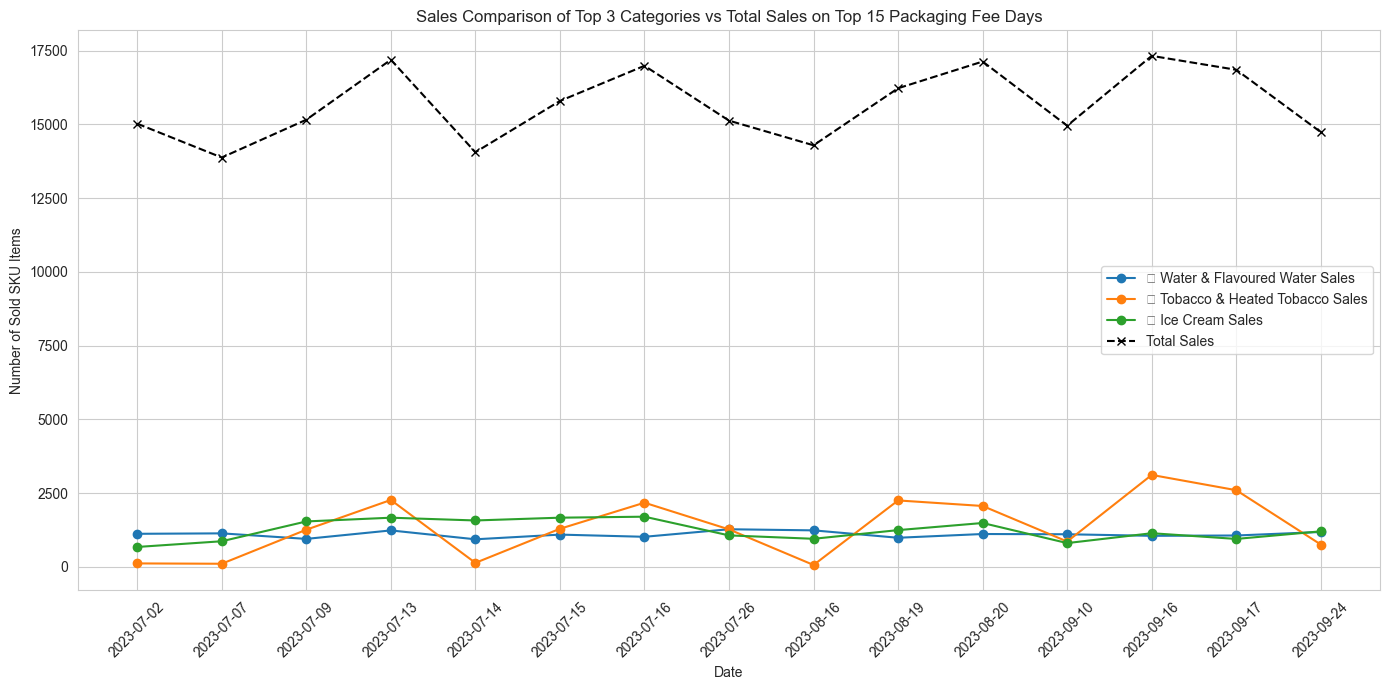

In [138]:
comparison_df = sales_per_day.merge(grouped_sales_top_3, on='time', suffixes=('', '_Top3'))

# Plot the comparison
plt.figure(figsize=(14, 7))
for category in top_3_categories['category_lvl_1']:
    category_data = comparison_df[comparison_df['category_lvl_1'] == category]
    plt.plot(category_data['time'], category_data['total_price_Top3'], label=category + ' Sales', marker='o')

plt.plot(sales_per_day['time'], sales_per_day['total_price'], label='Total Sales', color='k', linestyle='--', marker='x')

plt.title('Sales Comparison of Top 3 Categories vs Total Sales on Top 15 Packaging Fee Days')
plt.xlabel('Date')
plt.ylabel('Number of Sold SKU Items')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

When trying to figure out if there is any specific catrgory thats responsible for contributing to high
packaging cost so picked up 15 days that had highest packaging cost and plotted the top three SKU's that were 
sold on these dates. Turns out Tobacco & Heated Tobacco sales are highly co-linear with total sales on those
high packaging fee days . Also Water and Icecream sales have consistent sales through those days . Each of those 
categories accumulate 5% of sales which in total is 15% of total sales on these 15 days which is quite a big chunk.